## Модель текучесть дрп

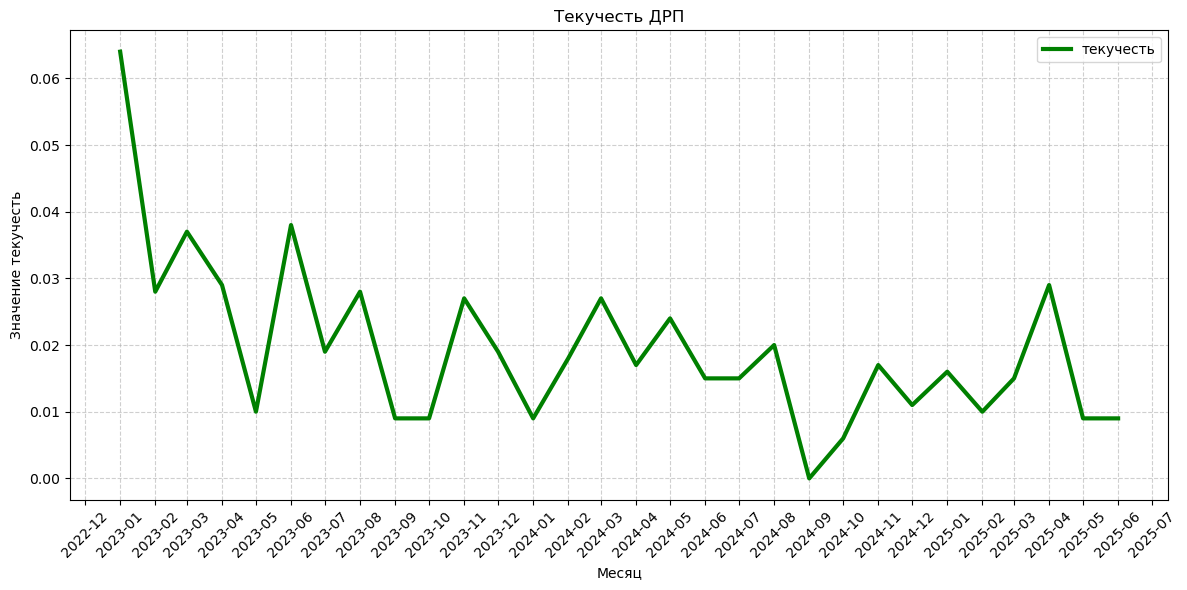

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

#ДЛЯ БАЗОВОЙ ПОДГОТОВКИ МОДЕЛИ

#ЗАВОДИМ ДАННЫЕ
df = pd.read_excel('turnover_drp.xlsx')
colums_list = df.columns.tolist()

df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['turnover'] = pd.to_numeric(df['turnover'], errors='coerce')

# СТРОИМ ГРАФИК
df = df.dropna(subset=['date', 'turnover']).set_index('date').asfreq('MS')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['turnover'], label='текучесть', linewidth=3, color = 'green')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('Текучесть ДРП')
ax.set_xlabel('Месяц'); ax.set_ylabel('Значение текучесть')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

### стационарность

In [5]:
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("РЯД НЕ СТАЦИОНАРЕН")
    else:
        print("РЯД СТАЦИОНАРЕН")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['turnover'], 'Counts')

Results of ADF Test on Counts:
ADF Statistic: -1.7193291556571293
p-value: 0.42118203643648194
РЯД НЕ СТАЦИОНАРЕН
Critical Value (1%): -3.7883858816542486
Critical Value (5%): -3.013097747543462
Critical Value (10%): -2.6463967573696143




### трейн и тест

In [8]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]   
test  = df.iloc[train_size:]   

print("Размер train:", train.shape)
print("Размер test :", test.shape)

Размер train: (24, 1)
Размер test : (6, 1)


### дифф 1

In [11]:
train_diff1 = train["turnover"].diff().dropna()
print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

ADF p-value после 1 diff: 0.7856123633672827
Results of ADF Test on Train after 1st diff:
ADF Statistic: -0.9071389657137242
p-value: 0.7856123633672827
РЯД НЕ СТАЦИОНАРЕН
Critical Value (1%): -4.068853732362312
Critical Value (5%): -3.1271488757396453
Critical Value (10%): -2.7017297633136095




### дифф 2

In [18]:
train_diff2 = train["turnover"].diff().diff().dropna()
print("ADF p-value после 2 diff:", adfuller(train_diff2)[1])
test_stationarity(train_diff2, "Train after 1st diff")

ADF p-value после 2 diff: 1.1675656810158873e-15
Results of ADF Test on Train after 1st diff:
ADF Statistic: -9.29278587284768
p-value: 1.1675656810158873e-15
РЯД СТАЦИОНАРЕН
Critical Value (1%): -4.137829282407408
Critical Value (5%): -3.1549724074074077
Critical Value (10%): -2.7144769444444443




### PACF - p

<Figure size 800x400 with 0 Axes>

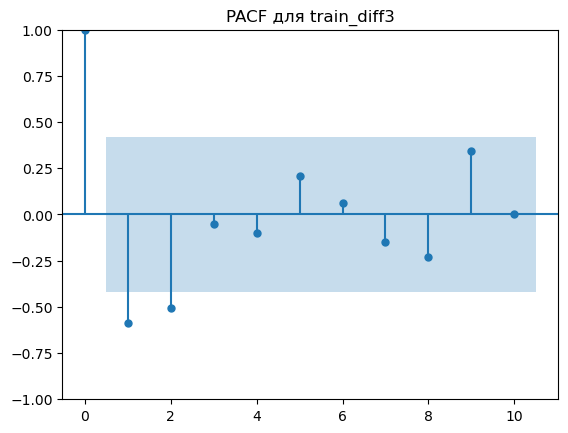

In [42]:
plt.figure(figsize=(8,4))
plot_pacf(train_diff2, lags=10, method="ywm")  # "ywm" – более устойчивая оценка
plt.title("PACF для train_diff3")
plt.show()

### ACF - q

In [44]:
plt.figure(figsize=(8,4))
plot_acf(train_diff2, lags=10)
plt.title("ACF для train_diff2")
plt.show()

NameError: name 'plot_acf' is not defined

<Figure size 800x400 with 0 Axes>

### ARIMA (тест модели)

--------------------
--------------------
                               SARIMAX Results                                
Dep. Variable:               turnover   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  69.110
Date:                Thu, 18 Sep 2025   AIC                           -132.221
Time:                        22:47:40   BIC                           -128.815
Sample:                    01-01-2023   HQIC                          -131.364
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3180      0.421     -0.755      0.450      -1.143       0.507
ma.L1         -0.4848      0.360     -1.347      0.178      -1.190       0.220
sigma2    

C:\Users\eugen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


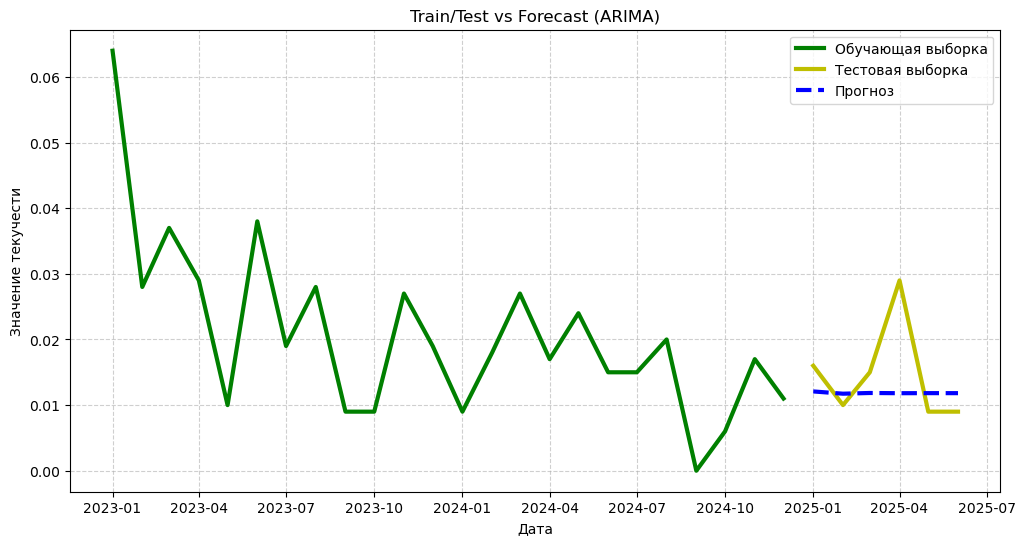

date
2025-01-01    0.012081
2025-02-01    0.011737
2025-03-01    0.011847
2025-04-01    0.011812
2025-05-01    0.011823
2025-06-01    0.011820
Freq: MS, Name: forecast, dtype: float64


In [49]:
#модель
p = 1
d = 1
q = 1

model = ARIMA(train["turnover"], order=(p, d, q))
print('--------------------')
model_fit = model.fit()
print('--------------------')
print(model_fit.summary())


#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["turnover"] - forecast) / test["turnover"])) * 100
print('--------------------')
print(f"MAPE: {mape:.2f}%")

#проверка MAE
y_true = test["turnover"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print('--------------------')
print(f"MAE: {mae:.2f}")

#печать прогнозных значений
forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print('--------------------')
print (forecast)

plt.figure(figsize=(12,6))
plt.plot(train.index, train["turnover"], label="Обучающая выборка", linewidth=3, color = 'green')
plt.plot(test.index, test["turnover"], label="Тестовая выборка", linewidth=3, color="y")
plt.plot(test.index, forecast, label="Прогноз", linewidth=3, linestyle='--', color="blue")

plt.title("Train/Test vs Forecast (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Значение текучести")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print (forecast)

### Optuna

[I 2025-09-18 22:50:21,445] A new study created in memory with name: no-name-2c051c90-30d5-46f8-b37f-5a01a81b24e0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-18 22:50:21,507] Trial 0 finished with value: 46.64285878667781 and parameters: {'p': 3, 'd': 0, 'q': 0}. Best is trial 0 with value: 46.64285878667781.
[I 2025-09-18 22:50:21,529] Trial 1 finished with value: 29.570752893871944 and parameters: {'p': 0, 'd': 1, 'q': 2}. Best is trial 1 with value: 29.570752893871944.
[I 2025-09-18 22:50:21,559] Trial 2 finished with value: 34.97438013252072 and parameters: {'p': 2, 'd': 1, 'q': 0}. Best is trial 1 with value: 29.570752893871944.
[I 2025-09-18 22:50:21,703] Trial 3 finished with value: 45.448804029102206 and parameters: {'p': 4, 'd': 0, 'q': 4}. Best is trial 1 with value: 29.570752893871944.
[I 2025-09-18 22:50:21,798] Trial 4 finished with value: 29.995634106273624 and parameters: {'p': 4, 'd': 1, 'q': 2}. Best is trial 1 with value: 29.570752893871944.
[I 2025-09-18 22:50:21,910] Trial 5 finished with value: 35.82208788406223 and parameters: {'p': 1, 'd': 1, 'q': 4}. Best is trial 1 with value: 29.570752893871944.
[I 2025-

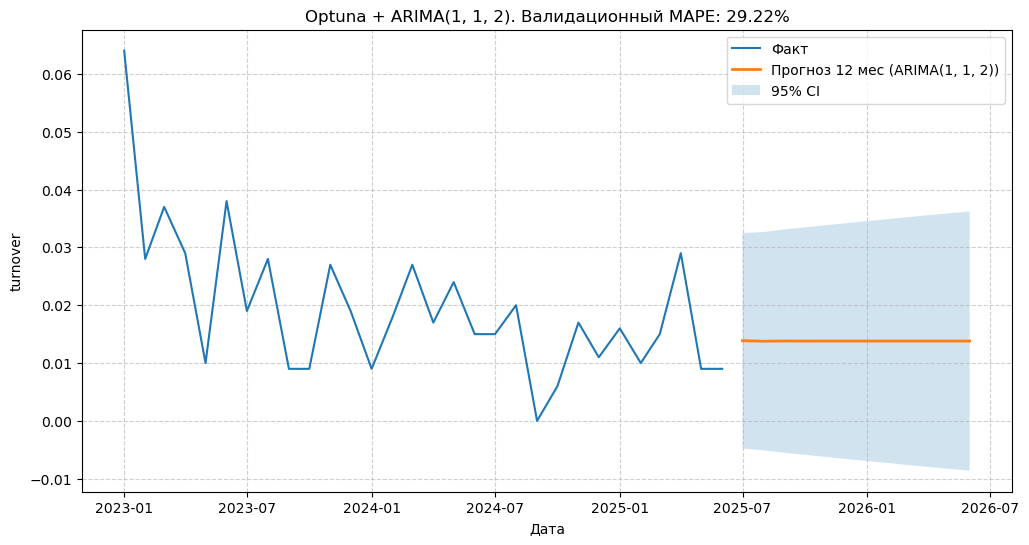

In [55]:


import warnings, numpy as np, pandas as pd, optuna
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

# ========= 1) ДАННЫЕ =========
df = pd.read_excel("turnover_drp.xlsx")                 # ваш файл
df["date"]  = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
df["turnover"] = pd.to_numeric(df["turnover"], errors="coerce")
df = df.dropna(subset=["date","turnover"]).sort_values("date").set_index("date")

# частота ряда (важно для корректного прогноза)
freq = pd.infer_freq(df.index)
if freq is None:                                # подставьте при необходимости
    freq = "MS"                                 # месяцы с начала месяца: MS | конец месяца: M
s = df["turnover"].asfreq(freq).interpolate()

# тестовый горизонт = 12 последних точек
TEST_STEPS = min(12, max(1, len(s)//5))         # если ряд короткий, берём 20%
train, test = s.iloc[:-TEST_STEPS], s.iloc[-TEST_STEPS:]

# ========= 2) ЦЕЛЕВАЯ ФУНКЦИЯ =========
def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

def objective(trial):
    # узкие, но практичные диапазоны (чтобы меньше «падало» по линалгу)
    p = trial.suggest_int("p", 0, 4)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 4)

    try:
        model = ARIMA(train, order=(p,d,q),
                      enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit()
        fc = res.get_forecast(steps=len(test)).predicted_mean
        return mape(test, fc)
    except Exception:
        # неустойчивая модель — даём большой штраф
        return 1e9

# ========= 3) ОПТИМИЗАЦИЯ =========
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_mape   = study.best_value
print(f"Лучшие параметры: {best_params}, MAPE на валидации: {best_mape:.2f}%")

# ========= 4) ФИНАЛЬНАЯ МОДЕЛЬ НА ВСЁМ РЯДЕ + ПРОГНОЗ 12 =========
p, d, q = best_params["p"], best_params["d"], best_params["q"]
final = ARIMA(s, order=(p,d,q),
              enforce_stationarity=False, enforce_invertibility=False).fit()

future = final.get_forecast(steps=12)
yhat   = future.predicted_mean
ci     = future.conf_int()

print("\nПрогноз на 12 периодов:")
print(yhat)

# ========= 5) ВИЗУАЛИЗАЦИЯ =========
plt.figure(figsize=(12,6))
plt.plot(s.index, s, label="Факт")
plt.plot(yhat.index, yhat, label=f"Прогноз 12 мес (ARIMA{p,d,q})", linewidth=2)
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="95% CI")
plt.title(f"Optuna + ARIMA{p,d,q}. Валидационный MAPE: {best_mape:.2f}%")
plt.xlabel("Дата"); plt.ylabel("turnover"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Prophet

22:51:28 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


MAE : 0.01
MAPE: 54.18%


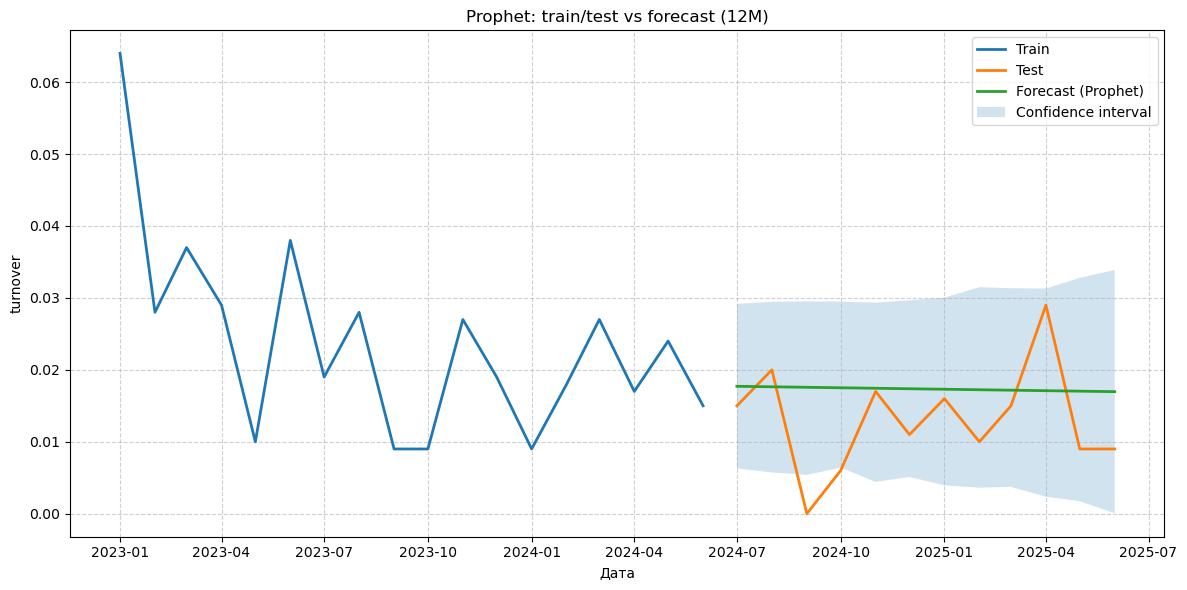

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# --- 1) Загрузка и подготовка ---
df = pd.read_excel("turnover_drp.xlsx")
df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['turnover'] = pd.to_numeric(df['turnover'], errors='coerce')
df = df.dropna(subset=['date','turnover']).sort_values('date')

# гарантируем месячную частоту (опционально, если есть пропуски месяцев)
# df = df.set_index('date').asfreq('MS').reset_index()

# prophet-формат
data = df.rename(columns={'date':'ds', 'turnover':'y'})

# --- 2) Трейн/тест: последние 12 мес = тест ---
horizon = 12
train = data.iloc[:-horizon].copy()
test  = data.iloc[-horizon:].copy()

# --- 3) Модель Prophet ---
# для месячных рядов выключаем недельную/дневную сезонность
m = Prophet(
    growth='linear',
    yearly_seasonality='auto',
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,   # можно ослабить/усилить гибкость тренда (0.05..1.0)
    seasonality_mode='additive'    # при ускоряющемся росте попробуй 'multiplicative'
)

m.fit(train)

# --- 4) Прогноз на 12 месяцев вперёд ---
future = m.make_future_dataframe(periods=horizon, freq='MS')  # 'MS' = Month Start
forecast = m.predict(future)

# --- 5) Берём только прогнозный горизонт и считаем метрики ---
fcst_tail = forecast.tail(horizon).copy()
y_true = test['y'].to_numpy(dtype=float)
y_pred = fcst_tail['yhat'].to_numpy(dtype=float)

mae  = np.mean(np.abs(y_true - y_pred))
# защита от деления на ноль
denom = np.where(y_true == 0, np.nan, y_true)
mape = np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- 6) Визуализация ---
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train', linewidth=2)
plt.plot(test['ds'],  test['y'],  label='Test', linewidth=2)
plt.plot(fcst_tail['ds'], fcst_tail['yhat'], label='Forecast (Prophet)', linewidth=2)

# доверительный интервал Prophet (по умолчанию 80% или 95% в зависимости от версии; можно изменить m.interval_width)
plt.fill_between(
    fcst_tail['ds'],
    fcst_tail['yhat_lower'],
    fcst_tail['yhat_upper'],
    alpha=0.2, label='Confidence interval'
)

plt.title("Prophet: train/test vs forecast (12M)")
plt.xlabel("Дата")
plt.ylabel("turnover")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7) (опционально) компоненты модели ---
# m.plot_components(forecast); plt.show()